In [ ]:
# Uncomment if using collab
#!nvidia-smi

In [0]:
# Keras is used for loading the model
import keras
from keras.models import Model
from keras.models import load_model


from keras.utils.np_utils import to_categorical
from keras import backend as K
from keras.utils import generic_utils


# We also need sys, os and copy for some processes to retrieve the data (the test set
# and model) as well as to install some new modules in colab
import sys
import os
import copy

# Importing matplotlib, numpy and pandas for handling the test set data and 
# later for displaying the original image + explanations created by SHAP, Gradcam
%matplotlib inline
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import PIL
from PIL import Image
import scipy


In [0]:
#This version is not installed on collab
pip install scipy==1.1.0

In [0]:
# Installing SHAP and keras-vis through pip (Also not on collab)
!{sys.executable} -m pip install shap
!{sys.executable} -m pip install keras-vis

# Importing SHAP and keras-vis3

In [0]:
import shap
from vis import visualization

In [0]:
# Connect to a particular Google Drive folder (and place it in the '/content/gdrive'
# subdirectory).
from google.colab import files, drive
drive.mount('/content/gdrive', force_remount=True) # to ensure that the process can be easily redone in the same runtime

Mounted at /content/gdrive


In [0]:
# Change the current operating directory to the Google Drive (which contains our data)
os.chdir('/content/gdrive/My Drive/zero_to_deep_learning_udemy/Project')

In [0]:
# Load the model using the saved InceptionV3 weights
model = load_model('YOUR_MODEL')

W0728 13:17:32.100417 140265400485760 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0728 13:17:32.101536 140265400485760 nn_ops.py:4224] Large dropout rate: 0.593453 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0728 13:17:40.573575 140265400485760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0728 13:17:40.585446 140265400485760 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow

In [0]:
from vis.utils import utils
from keras import layers, activations

#Assorted modifications for model compatibility with gradCAM
gmodel = copy.deepcopy(model)
layer_idx = utils.find_layer_idx(gmodel,'dense_2')

#swap with softmax with linear classifier for the reasons mentioned above
gmodel.layers[layer_idx].activation = activations.linear
gmodel = utils.apply_modifications(gmodel)

W0728 13:20:36.070702 140265400485760 nn_ops.py:4224] Large dropout rate: 0.593453 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0728 13:24:58.203795 140265400485760 nn_ops.py:4224] Large dropout rate: 0.593453 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [0]:
%run utils.py

In [0]:
test_df = pd.read_pickle('NvAndMelNoDuplicatesTestSet.zip')
# Change the idx column to be '0' where the diagnosis of the lesion was
# melanoma, and '1' when the diagnosis is nevi
test_df['idx'] = np.where(test_df['id'] == 'mel', 0 , 1)

# Save a new table 'features' to be test_df, without the idx column
features=test_df.drop(columns=['idx'], axis = 1)
# Create a new table with just the correct diagnosis (0 for melanoma, 1 for nevi)
target=test_df['idx']

# Change features to be a numpy array of image pixel data ((R, G, B))
features = np.asarray(features['image'].tolist())
# Normalise this data in an alternate table to be values from 0 ... 1
# e.g. 255 -> 1, 0 --> 0
# Normalises for original prediction and evaluation of model, the SHAP funciton below requires non normalised data
# TODO: Standarise this so SHAP takes normalised
features2 = features / 255

# Convert the data to one-hot encoding
target_cat = to_categorical(target, num_classes = 2)

# Get predictions for image data
# e.g.
# Index 0 : [0.9222, 0.0778]
# Index 1 : [0.4500, 0.5500]
# etc..
# This represents likelihood of melanoma and nevi respectively (according to the model)
y_pred = model.predict(features2, verbose=1)

# Create a new dataframe with entries for each element of the test set
# Include an ID, diagnosis, and % likelihoods for each diagnosis from the model
df = pd.DataFrame(columns=['ID', 'Dx', '% Mel', '% Nev'],index=[i for i in range(400)])
df['ID'] = df.index

# Create dictionaries to contain actual diagnosis and probabilities from the model
dx_d = {}
Pmel = {}
Pnev = {}
# Take the actual diagnoses from where we retrieved them earlier
y_test_cat = target_cat

# For each element in the test set:
for ind in range(400):
    # Append the diagnosis and predictions to their respective dictionaries
    if y_test_cat[ind][0] == 1.0:
        diagnosis = 'Melanoma'
    elif y_test_cat[ind][1] == 1.0:
        diagnosis = 'Nevus'
    dx_d[ind] = diagnosis
    Pmel[ind] = y_pred[ind][0]
    Pnev[ind] = y_pred[ind][1]
    
# Take the above dictionaries and insert them into the data frame
df['Dx'] = df['ID'].map(dx_d)
df['% Mel'] = df['ID'].map(Pmel)
df['% Nev'] = df['ID'].map(Pnev)

# Change the prediction likelihoods to be floats 
df = df.astype({"% Mel": float, "% Nev": float})

#df = df.iloc[id_list]

# Print the first 5 entries in the data frame
print('Unseen set') 
#print(df)

400/400 [==============================] - 2s 5ms/step
Unseen set
      ID        Dx     % Mel     % Nev
0      0  Melanoma  0.766971  0.317237
1      1  Melanoma  0.898871  0.306985
2      2  Melanoma  0.659791  0.282926
3      3  Melanoma  0.702128  0.274500
4      4  Melanoma  0.778674  0.194303
5      5  Melanoma  0.580099  0.313759
6      6  Melanoma  0.680306  0.363760
7      7  Melanoma  0.928041  0.064225
8      8  Melanoma  0.592183  0.165154
9      9  Melanoma  0.536071  0.261188
10    10  Melanoma  0.365546  0.628575
11    11  Melanoma  0.502183  0.486967
12    12  Melanoma  0.698077  0.341144
13    13  Melanoma  0.430408  0.156819
14    14  Melanoma  0.827299  0.200067
15    15  Melanoma  0.743537  0.514937
16    16  Melanoma  0.919668  0.360337
17    17  Melanoma  0.734827  0.166528
18    18  Melanoma  0.730815  0.220403
19    19  Melanoma  0.482599  0.214596
20    20  Melanoma  0.821329  0.174543
21    21  Melanoma  0.844334  0.130006
22    22  Melanoma  0.330772  0.50469

In [0]:
#df.to_csv('predictions.csv')
#if you want to save predictions for your model uncomment this

In [0]:
model.evaluate(features2, target_cat)

400/400 [==============================] - 8s 20ms/step


[0.4223445188999176, 0.825]

In [0]:
from utils import *

/usr/local/lib/python3.6/dist-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib/python3.6/dist-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \



[[0.65979093 0.28292584]]


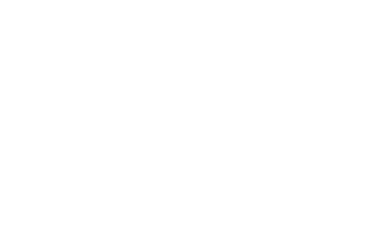

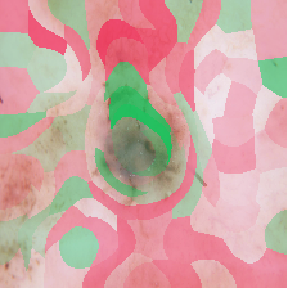

<Figure size 432x288 with 0 Axes>

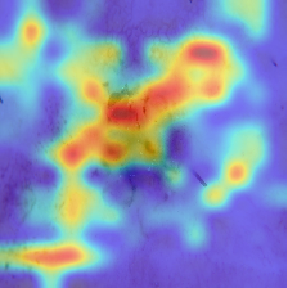

In [0]:
#Produces a single shap and GradCAM image for the 3rd image in features
Shap_single(features[2], model, gmodel, save = False, filename = None, relative_path = None)

In [0]:
#Features is unstandardised numpy array of test images
#Model is keras model
#Gmodel is altered for gradcam
#Path is name of folder relative to current directory

#generates multiple shap images, i.e. will generate images for every image contained in features (which is unstandardised)
#Last argument is the relative path for where you want to save images 
batch_shap(features, model, gmodel, 'OutputDirectory/')